In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/mft-theory/')
from cluster import *
from core import *
from empirics import *
from functions import *
from ode_methods import *
from plotting import *
from theory import *
from utils import *
import matplotlib.pyplot as plt

In [2]:
### --- SET UP ALL CONFIGS --- ###
from itertools import product
n_seeds = 10
macro_configs = config_generator()

micro_configs = tuple(product(macro_configs, list(range(n_seeds))))
prototype = False

### --- SELECT PARTICULAR CONFIG --- ###
try:
    i_job = int(os.environ['SLURM_ARRAY_TASK_ID']) - 1
except KeyError:
    i_job = 0
    prototype = True
params, i_seed = micro_configs[i_job]
i_config = i_job//n_seeds

new_random_seed_per_condition = True
if new_random_seed_per_condition:
    np.random.seed(i_job)
else: #Match random seeds across conditions
    np.random.seed(i_seed)

In [3]:
#Network size
N = 1000
#Random connectivity
g = 3.8
J = g * np.random.normal(0, 1/np.sqrt(N), (N, N))

#Structure
s = 2.6
sigma_diag = 1.6
sigma_off = 0.8
sigma_mn = np.array([[sigma_diag, -sigma_off],
                     [sigma_off, sigma_diag]])
sigma_mm = np.eye(2)
n_var = 4
sigma_nn = n_var * np.eye(2)

covariance_top = np.hstack([sigma_mm, sigma_mn])
covariance_bot = np.hstack([sigma_mn.T, sigma_nn])
covariance = np.vstack([covariance_top, covariance_bot])

loadings = np.random.multivariate_normal(np.zeros(4), covariance, size=N)

m1 = loadings[:,0]
m2 = loadings[:,1]
n1 = loadings[:,2]
n2 = loadings[:,3]
M = np.multiply.outer(m1, n1) + np.multiply.outer(m2, n2)

#Recompute orthogonal m1 and m2 for analysis
U, S, VT = np.linalg.svd(M)
m1 = U[:,0]
m2 = U[:,1]
    
#Combine into one connectivity
W = J + s*M / N

In [4]:
rnn = Time_Cts_RNN(W, tanh, g=1)
ode_method = Euler(0.05)
sim = Simulation(rnn)
x_init = np.random.normal(0, 1/np.sqrt(N), N)
T = 1000
sim.run(T=T, ode_method=ode_method, x_init=x_init, monitors=['rnn.x', 'rnn.phi', 'phi_lpf', 't'], T_monitor=0.1*T,
        T_monitor_interval=1, compute_phi_lpf=True)

Progress: 10.0% complete 
Time Elapsed: 0.4s 

Progress: 20.0% complete 
Time Elapsed: 0.8s 

Progress: 30.0% complete 
Time Elapsed: 1.2s 

Progress: 40.0% complete 
Time Elapsed: 1.6s 

Progress: 50.0% complete 
Time Elapsed: 1.9s 

Progress: 60.0% complete 
Time Elapsed: 2.4s 

Progress: 70.0% complete 
Time Elapsed: 2.8s 

Progress: 80.0% complete 
Time Elapsed: 3.2s 

Progress: 90.0% complete 
Time Elapsed: 3.6s 



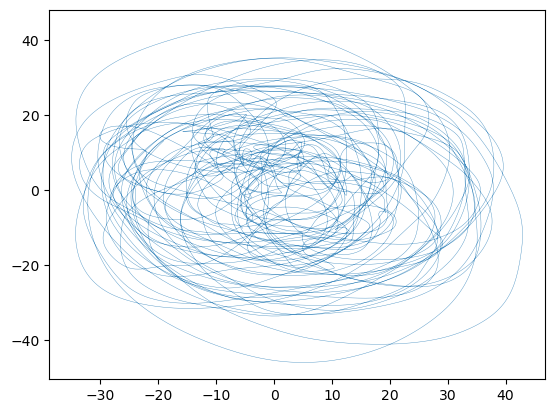

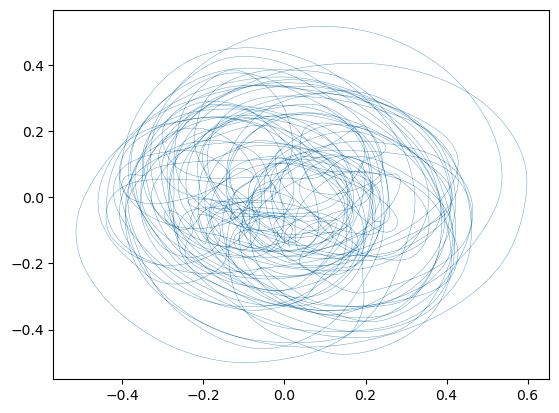

In [5]:
m = np.hstack([m1.reshape(-1, 1), m2.reshape(-1, 1)])
x = sim.mons['rnn.x']
r = sim.mons['rnn.phi']
k = np.linalg.pinv(m).dot(x.T)
phi_lpf = sim.mons['phi_lpf']
kappa_emp = phi_lpf.dot(np.array([n1, n2]).T) / N
Delta_emp = np.fft.irfft((np.abs(np.fft.rfft(x, axis=0, norm='ortho'))**2).mean(1))
if prototype:
    plt.figure()
    plt.plot(k[0], k[1], alpha=0.8, linewidth=0.3)
    plt.figure()
    plt.plot(kappa_emp[:,0], kappa_emp[:,1], alpha=0.8, linewidth=0.3)

In [ ]:
processed_data = Delta_emp[:1000]

if not prototype:
    del sim.rnn.W
    for key in ['rnn.x', 'rnn.phi', 'phi_lpf', 't']:
        try:
            del sim.mons[key]
        except KeyError:
            pass

In [ ]:
### --- SAVE RESULTS -- ###
result = {'sim': sim, 'i_seed': i_seed, 'config': params,
          'i_config': i_config, 'i_job': i_job}
try:
    result['processed_data'] = processed_data
except NameError:
    pass
    
try:
    save_dir = os.environ['SAVEDIR']
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    save_path = os.path.join(save_dir, 'result_{}'.format(i_job))

    with open(save_path, 'wb') as f:
        pickle.dump(result, f)
except KeyError:
    pass

In [6]:
###Truncate file above
file_name = 'limit_cycles_theory'
job_name = 'delta_emp_N=16k'
project_dir = '/home/om2382/low-rank-dims/'
main_script_path = os.path.join(project_dir, 'cluster_main_scripts', job_name + '.py')
get_ipython().run_cell_magic('javascript', '', 'IPython.notebook.save_notebook()')
get_ipython().system('jupyter nbconvert --to script --no-prompt {}.ipynb'.format(file_name))
get_ipython().system('awk "/###Truncate/ {{exit}} {{print}}" {}.py'.format(file_name))
get_ipython().system('sed -i "/###Truncate/Q" {}.py'.format(file_name))
get_ipython().system('mv {}.py {}'.format(file_name, main_script_path))

<IPython.core.display.Javascript object>

[NbConvertApp] Converting notebook limit_cycles_theory.ipynb to script
[NbConvertApp] Writing 6259 bytes to limit_cycles_theory.py
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac65bbf6f28> <built-in function print>
awk: cmd. line:1:                       ^ syntax error
awk: cmd. line:1: /###Truncate/ <IPython.core.autocall.ZMQExitAutocall object at 0x2ac65bbf6f28> <built-in function print>
awk: cmd. line:1:                                                                                ^ syntax error


In [7]:
###Submit job to cluster
n_jobs = len(micro_configs)
write_job_file(job_name, py_file_name='{}.py'.format(job_name), mem=16, n_hours=24)
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
job_id_1 = submit_job(job_script_path, n_jobs)

rm: cannot remove ‘/home/om2382/low-rank-dims/results/misc/delta_emp_N=16k/result_*’: No such file or directory
sending incremental file list

sent 1,391 bytes  received 28 bytes  2,838.00 bytes/sec
total size is 198,749  speedup is 140.06


In [4]:
###Get job status
get_ipython().system('squeue -u om2382')

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
         1963506_1     burst delta_em   om2382  R      23:09      1 ax13
         1963506_2     burst delta_em   om2382  R      23:09      1 ax13
         1963506_3     burst delta_em   om2382  R      23:09      1 ax13
         1963506_4     burst delta_em   om2382  R      23:09      1 ax13
         1963506_5     burst delta_em   om2382  R      23:09      1 ax13
         1963506_6     burst delta_em   om2382  R      23:09      1 ax13
         1963506_7     burst delta_em   om2382  R      23:09      1 ax13
         1963506_8     burst delta_em   om2382  R      23:09      1 ax17
         1963506_9     burst delta_em   om2382  R      23:09      1 ax17
        1963506_10     burst delta_em   om2382  R      23:09      1 ax17
           1963505     burst  jupyter   om2382  R      28:30      1 ax05


In [3]:
project_dir = '/home/om2382/low-rank-dims/'
job_name = 'delta_emp_N=16k'
job_script_path = os.path.join(project_dir, 'job_scripts', job_name + '.s')
configs_array, results_array, key_order, sim_dict = unpack_processed_data(job_script_path)

UnboundLocalError: cannot access local variable 'configs_array' where it is not associated with a value

In [4]:
mft = run_low_rank_dmft(g=g, s=s, T=100, dt=0.025)
Delta = mft['Delta']

NameError: name 'g' is not defined

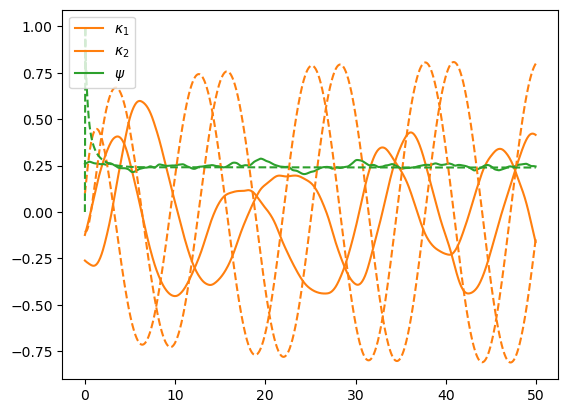

In [24]:
time_emp = np.arange(0, 50, 0.05)
time_mft = np.arange(0, 50, 0.025)
plt.plot(time_emp, kappa_emp[:len(time_emp),0], color='C1')
plt.plot(time_emp, kappa_emp[:len(time_emp),1], color='C1')
plt.plot(time_emp, rnn.activation.f_prime(x).mean(-1)[:len(time_emp)], color='C2')
plt.plot(time_mft, mft['kappa'][:len(time_mft),0], color='C1', linestyle='--')
plt.plot(time_mft, mft['kappa'][:len(time_mft),1], color='C1', linestyle='--')
plt.plot(time_mft, mft['psi'][:len(time_mft)], color='C2', linestyle='--')
plt.legend(['$\kappa_1$', '$\kappa_2$', '$\psi$'])

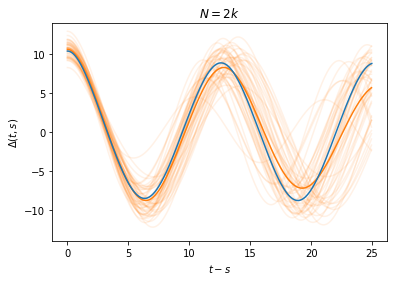

In [56]:
time_emp = np.arange(0, 25, 0.05)
time_mft = np.arange(0, 25, 0.025)
fig = plt.figure()
for i in range(50):
    Delta_emp = results_array[i]
    plt.plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.1)
plt.plot(time_emp, results_array.mean(0)[:len(time_emp)], color='C1')
plt.plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
#plt.xlim(-1, 50)
plt.ylim([-14, 14])
plt.xlabel('$t - s$')
plt.ylabel('$\Delta(t, s)$')
plt.title('$N = 2k$')
fig.savefig('figs/N=2k_theory_sim.pdf', dpi=300)
#plt.show()
#plt.plot(time_emp, kappa_emp[:len(time_emp)])
#plt.figure()
#plt.plot(time_mft, mft['kappa'][:len(time_mft)])

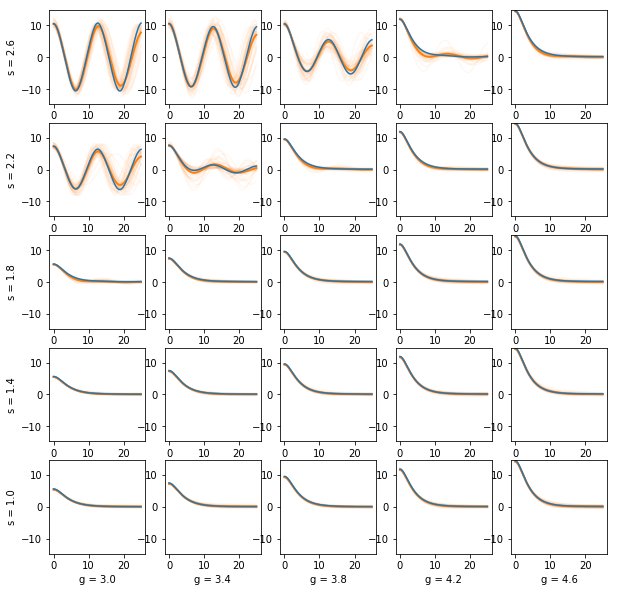

In [126]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
time_emp = np.arange(0, 25, 0.05)
time_mft = np.arange(0, 25, 0.025)
D = np.amax(np.abs(results_array))
for i_g, g in enumerate(np.arange(3, 5, 0.4)):
    for i_s_, s in enumerate(np.arange(1, 3, 0.4)):
        i_s = 4 - i_s_
        mft = run_low_rank_dmft(g=g, s=s, T=50, dt=0.025)
        Delta = mft['Delta']
        for i_seed in range(40):
            Delta_emp = results_array[i_s_, i_g, i_seed]
            ax[i_s, i_g].plot(time_emp, Delta_emp[:len(time_emp)], color='C1', alpha=0.05)
        ax[i_s, i_g].plot(time_emp, results_array[i_s_, i_g].mean(0)[:len(time_emp)], color='C1', linewidth=2)
        ax[i_s, i_g].plot(time_mft, np.roll(Delta[len(Delta)//2], -len(Delta)//2)[:len(time_mft)])
        #ax[i_s, i_g].axis('off')
        ax[i_s, i_g].set_ylim([-D, D])
        ax[i_s, 0].set_ylabel('s = {:0.1f}'.format(s))
        ax[4, i_g].set_xlabel('g = {:0.1f}'.format(g))
fig.savefig('figs/theory_sim_g35_s13.pdf')